In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, TFSegformerForSemanticSegmentation
import pandas as pd
import cv2
import numpy as np

In [2]:
WIDTH = 512
HEIGHT = 512
dataset_path = 'MosaicsUCSD_sam_100'
output_path = 'test_predictions_mixed_100'

In [3]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, sub_path, "images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "labels")

        print(self.img_dir)
        print(self.ann_dir)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), f"There must be as many images as there are segmentation maps. Number of images: {len(self.images)}, Number of annotations: {len(self.annotations)}"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Construct paths to the image and annotation
        image_path = os.path.join(self.img_dir, self.images[idx])
        annotation_path = os.path.join(self.ann_dir, self.annotations[idx])

        # Read the image and annotation using OpenCV
        image = cv2.imread(image_path)
        # Check if the image was loaded successfully
        if image is None:
            print(f"Failed to load image from {image_path}")
        else:
            try:
                # Attempt to convert the image color space from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            except cv2.error as e:
                print(f"Failed to convert image color space: {e}")

        segmentation_map = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert the OpenCV image to a PIL Image for the transformation
        image = Image.fromarray(image)
        segmentation_map = Image.fromarray(segmentation_map)

        # Resize the image and segmentation map to a fixed size, if needed
        # image = TF.resize(image, (HEIGHT, WIDTH))
        # segmentation_map = TF.resize(segmentation_map, (HEIGHT, WIDTH), interpolation=TF.InterpolationMode.NEAREST)

        # Apply the transformations if any
        if self.transforms is not None:
            image = self.transforms(image)
        else:
            # Convert the PIL Image to a tensor (this also permutes dimensions to C x H x W)
            image = TF.to_tensor(image)

        # Convert the PIL Image back to a NumPy array if your processing pipeline requires it
        segmentation_map = np.array(segmentation_map)

        # Convert the segmentation map to a tensor
        segmentation_map = torch.tensor(segmentation_map, dtype=torch.long)


        # Prepare the return dictionary
        return_dict = {'pixel_values': image, 'labels': segmentation_map}

        # Include the filename in the return dictionary if not in training mode
        # Inside your method, after checking if not in training mode
        if not self.train:
            with Image.open(image_path) as img:
                width, height = img.size
            return_dict['filename'] = self.images[idx]
            return_dict['dim'] = (width, height)

        return return_dict

In [4]:
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.05),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])

In [5]:
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
train_dataset = ImageSegmentationDataset(root_dir=dataset_path, feature_extractor=feature_extractor, transforms=transform)
test_dataset = ImageSegmentationDataset(root_dir=dataset_path, feature_extractor=feature_extractor, transforms=None, train=False)

MosaicsUCSD_mixed_100/train/images
MosaicsUCSD_mixed_100/train/labels
MosaicsUCSD_mixed_100/test/images
MosaicsUCSD_mixed_100/test/labels


/home/cesar/miniconda3/envs/mmlab/lib/python3.7/site-packages/transformers/models/segformer/feature_extraction_segformer.py:31: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  FutureWarning,


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(test_dataset))

Number of training examples: 3974
Number of validation examples: 696


In [7]:
encoded_inputs = train_dataset[1]
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [8]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [9]:
encoded_inputs["labels"]

tensor([[11, 11, 11,  ..., 12, 12, 12],
        [11, 11, 11,  ..., 12, 12, 12],
        [11, 11, 11,  ..., 12, 12, 12],
        ...,
        [12, 12, 12,  ..., 34, 34, 34],
        [12, 12, 12,  ..., 34, 34, 34],
        [12, 12, 12,  ..., 34, 34, 34]])

In [10]:
encoded_inputs["labels"].squeeze().unique()

tensor([11, 12, 29, 34])

In [11]:
# mask = encoded_inputs["labels"].numpy()

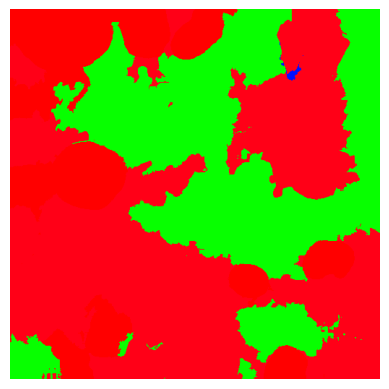

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'mask' is a grayscale image where each unique value represents a different color/segment
mask = encoded_inputs["labels"].numpy()
# Step 1: Identify unique colors
unique_colors = np.unique(mask)

# Step 2: Create a mapping to distinctive colors
# Generate a list of distinctive colors, one for each unique color in the mask.
# Here, we use a simple approach to generate colors evenly spaced in the HSV color space.
distinctive_colors = plt.cm.hsv(np.linspace(0, 1, len(unique_colors)))

# Create a dictionary mapping original color to distinctive color
color_mapping = {original_color: distinctive_color for original_color, distinctive_color in zip(unique_colors, distinctive_colors)}

# Step 3: Replace colors in the mask based on the mapping
# Create an RGB image where each unique color in the original mask is replaced with a distinctive color
rgb_mask = np.zeros(mask.shape + (3,), dtype=np.float32)
for original_color, distinctive_color in color_mapping.items():
    rgb_mask[mask == original_color] = distinctive_color[:3]  # Ignore the alpha channel in distinctive colors

# Step 4: Plot the modified mask
plt.imshow(rgb_mask)
plt.axis('off')  # Hide the axis
plt.show()

In [13]:
from torch.utils.data import DataLoader, random_split

total_size = len(train_dataset)
train_size = int(total_size * 0.8)  # 80% for training
validation_size = total_size - train_size  # 20% for validation

# Splitting the dataset
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Creating DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(validation_dataset, batch_size=4)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [14]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([4, 3, 512, 512])
labels torch.Size([4, 512, 512])


In [15]:
batch["labels"]

tensor([[[20, 20, 20,  ..., 34, 34, 34],
         [20, 20, 20,  ..., 34, 34, 34],
         [20, 20, 20,  ..., 34, 34, 34],
         ...,
         [34, 34, 34,  ..., 34, 34, 34],
         [34, 34, 34,  ..., 34, 34, 34],
         [34, 34, 34,  ..., 34, 34, 34]],

        [[34, 34, 34,  ..., 12, 12, 12],
         [34, 34, 34,  ..., 12, 12, 12],
         [34, 34, 34,  ..., 12, 12, 12],
         ...,
         [34, 34, 34,  ..., 12, 12, 12],
         [34, 34, 34,  ..., 12, 12, 12],
         [34, 34, 34,  ..., 12, 12, 12]],

        [[30, 30, 30,  ...,  8,  8,  8],
         [30, 30, 30,  ...,  8,  8,  8],
         [30, 30, 30,  ...,  8,  8,  8],
         ...,
         [34, 34, 34,  ..., 27, 27, 27],
         [34, 34, 34,  ..., 27, 27, 27],
         [34, 34, 34,  ..., 27, 27, 27]],

        [[34, 34, 34,  ..., 12, 12, 12],
         [34, 34, 34,  ..., 12, 12, 12],
         [34, 34, 34,  ..., 12, 12, 12],
         ...,
         [34, 34, 34,  ..., 34, 34, 34],
         [34, 34, 34,  ..., 34, 34, 

In [16]:
id2label = {0: "background", **{i: str(i) for i in range(1, 35)}}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

In [17]:
model_checkpoint = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    reshape_last_stage=True,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_fuse.weight', 'decode_head.linear

In [18]:
optimizer = AdamW(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

/home/cesar/miniconda3/envs/mmlab/lib/python3.7/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Model Initialized!


In [19]:
num_epochs = 15
epoch_train_losses = []
epoch_val_losses = []
for epoch in range(1, num_epochs+1):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        
        #print unique labels
        

        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # pixel_values = pixel_values.permute(0, 3, 1, 2)

        # print(pixel_values.shape)
        # print(pixel_values.dtype)
        # print(labels.shape)
        # print(labels.dtype)

        # check that all labels values are within the range of the number of classes
        assert torch.all(labels < num_labels), "A label value is out of the range of the number of classes."

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 0) # we don't include the background class in the accuracy calculation
        # Check if the mask is not empty
        # print(labels)
        if mask.any():
            pred_labels = predicted[mask].detach().cpu().numpy()
            true_labels = labels[mask].detach().cpu().numpy()
            accuracy = accuracy_score(pred_labels, true_labels)
        else:
            print("Warning: No valid labels found for accuracy calculation.")
            accuracy = 0
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 0) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    epoch_train_losses.append(sum(losses) / len(losses))
    epoch_val_losses.append(sum(val_losses) / len(val_losses))

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")
    
# Save the model
torch.save(model.state_dict(), dataset_path+".pth")

Epoch: 1


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6862098750358284         Train Loss: 1.36942100007579         Val Pixel-wise accuracy: 0.7095461364691968         Val Loss: 1.0301789566500104
Epoch: 2


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7547768182880803         Train Loss: 0.889168607026526         Val Pixel-wise accuracy: 0.7672433843910224         Val Loss: 0.7651987165661912
Epoch: 3


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.777934401400624         Train Loss: 0.7602995207099794         Val Pixel-wise accuracy: 0.786236273443355         Val Loss: 0.689689200427664
Epoch: 4


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7940573062455843         Train Loss: 0.6815878574203396         Val Pixel-wise accuracy: 0.7935763600955398         Val Loss: 0.6673471472371164
Epoch: 5


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8032048867195477         Train Loss: 0.637078071202872         Val Pixel-wise accuracy: 0.7999508965845501         Val Loss: 0.6306120762273894
Epoch: 6


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8161513504988419         Train Loss: 0.5854803329368807         Val Pixel-wise accuracy: 0.802472509644811         Val Loss: 0.6052263051121678
Epoch: 7


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8248703107199121         Train Loss: 0.5470831090174381         Val Pixel-wise accuracy: 0.7971619890585006         Val Loss: 0.624735950674843
Epoch: 8


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8292554734828778         Train Loss: 0.5259852531383622         Val Pixel-wise accuracy: 0.8022873994337962         Val Loss: 0.6187648113498736
Epoch: 9


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8328706093887424         Train Loss: 0.508811313738613         Val Pixel-wise accuracy: 0.8078928851124387         Val Loss: 0.6010705052907742
Epoch: 10


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8389927100685399         Train Loss: 0.48719584703820307         Val Pixel-wise accuracy: 0.8124804304754055         Val Loss: 0.5807679108339339
Epoch: 11


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8429727615618962         Train Loss: 0.46788952131316347         Val Pixel-wise accuracy: 0.8084896254175677         Val Loss: 0.6018302735671326
Epoch: 12


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.846518716933747         Train Loss: 0.4527633203088113         Val Pixel-wise accuracy: 0.8110991802603197         Val Loss: 0.5947529886236143
Epoch: 13


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.851678765499367         Train Loss: 0.4337970268613887         Val Pixel-wise accuracy: 0.8112917338594128         Val Loss: 0.6002336273241282
Epoch: 14


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8521498344448734         Train Loss: 0.43089024793801817         Val Pixel-wise accuracy: 0.8070486895660591         Val Loss: 0.6305473695448296
Epoch: 15


  0%|          | 0/795 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8569072830023987         Train Loss: 0.4128461796532637         Val Pixel-wise accuracy: 0.8118241796991054         Val Loss: 0.5979397686282594


PREDICT IN TEST IMAGES

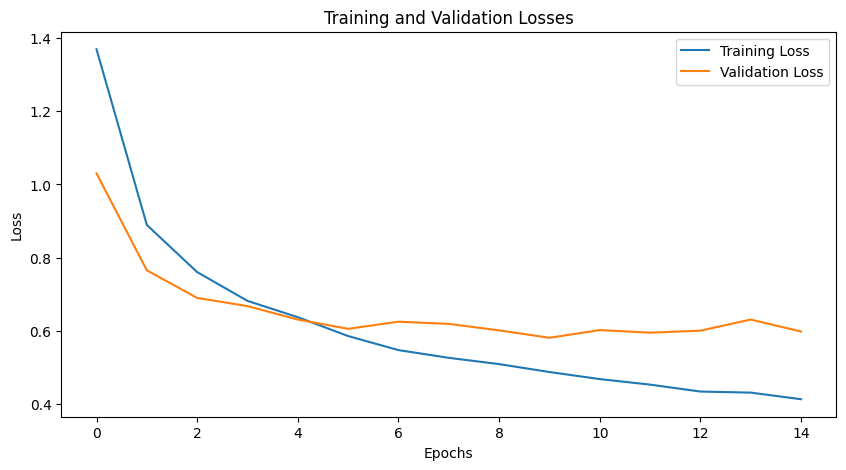

In [20]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score
import os
import pandas as pd
import cv2
import numpy as np
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

from PIL import Image
import matplotlib.pyplot as plt
from torch import nn

In [22]:
id2label = {0: "background", **{i: str(i) for i in range(1, 35)}}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

In [23]:
# Predict in test images
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    reshape_last_stage=True,
)

# Load the model weights
checkpoint = torch.load(dataset_path+".pth", map_location=device)
model.load_state_dict(checkpoint)

model = model.to(device)


/home/cesar/miniconda3/envs/mmlab/lib/python3.7/site-packages/transformers/models/segformer/feature_extraction_segformer.py:31: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  FutureWarning,
Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemantic

In [24]:
model.eval()

def rescale_image(image, new_shape):
    return cv2.resize(image, (new_shape[1], new_shape[0]), interpolation=cv2.INTER_NEAREST)

def get_predictions(predictions_numpy, batch):
    # Get the image sizes
    original_shape = batch['pixel_values'].shape[-2:]
    
    # Rescale the predictions to the original image size
    rescaled_predictions = [rescale_image(prediction, original_shape) for prediction in predictions_numpy]
    
    # Convert list of rescaled predictions to a NumPy array
    rescaled_predictions = np.array(rescaled_predictions)
    
    # Get the original images and labels
    images = batch['pixel_values'].cpu().numpy()
    images = images.transpose(0, 2, 3, 1)
    labels = batch['labels'].cpu().numpy()

    return images, labels, rescaled_predictions

# Plot the images, labels, and predictions
def plot_predictions(images, labels, predictions):
    fig, axs = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))
    for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Image")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(label)
        axs[i, 1].set_title("Label")
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(prediction)
        axs[i, 2].set_title("Prediction")
        axs[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

def label_to_rgb(label, palette):
    # Create an empty image with 3 channels for RGB
    rgb_image = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    
    # Map each label to its corresponding color
    for i, color in enumerate(palette):
        mask = (label == i)
        rgb_image[mask] = color
    
    return rgb_image

def convert_predictions_and_labels_to_rgb(labels, predictions, palette):
    labels_rgb = np.array([label_to_rgb(label, palette) for label in labels])
    predictions_rgb = np.array([label_to_rgb(prediction, palette) for prediction in predictions])
    return labels_rgb, predictions_rgb

all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch['pixel_values'].to(device)
        filenames = batch['filename']
        dims = batch['dim']

        widths, heights = dims
        widths_list = widths.tolist()
        heights_list = heights.tolist()
        dims_tuples = list(zip(widths_list, heights_list))
        
        # Get model predictions
        outputs = model(inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        
        # Move predictions to CPU and convert to numpy for further processing if necessary
        predictions_numpy = predicted_labels.cpu().numpy()

        # Process and plot predictions for the current batch
        images, labels, rescaled_predictions = get_predictions(predictions_numpy, batch)

        for filename, prediction_rgb, dim in zip(filenames, rescaled_predictions, dims_tuples):
            all_predictions.append((filename, prediction_rgb, dim))

# Reshape all predicitons to the original image size
os.makedirs(output_path, exist_ok=True)

for filename, prediction, dim in all_predictions:  # Adjusted to unpack filenames with predictions
    # Reshape prediction to the original image size
    # prediction = cv2.resize(prediction, dim, interpolation=cv2.INTER_NEAREST)
    output_dir = os.path.join(output_path, os.path.splitext(filename)[0] + '.png')  # Use original filename
    cv2.imwrite(output_dir, prediction)